### Содержание

####  Изучение данных из файла
 
#### Функции для расчета и анализа LTV, ROI, удержания и конверсии

#### Исследовательский анализ данных

####  Маркетинговый анализ

#### Оценка окупаемости рекламы для привлечения пользователей

#### Выводы и рекомендации
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.


### Описание исследования
Предоставлены данные о пользователях развлекательного приложения Procrastinate Pro+. Выявлено, что несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Требуется разобраться в причинах и помочь компании выйти в плюс.

#### Описание данных
Предоставлены данные о посещениях, заказах, затратах на маркетинг. Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

* `User Id` — уникальный идентификатор пользователя
* `Device` — категория устройства пользователя
* `Session start` — дата и время начала сессии
* `Session End` — дата и время окончания сессии
* `Channel` — идентификатор рекламного источника, из которого пришел пользователь
* `Region` - страна пользователя

Таблица orders_log_short (информация о заказах):

* `User Id` — уникальный id пользователя, который сделал заказ
* `Event Dt` — дата и время покупки
* `Revenue` — выручка

Таблица costs_short (информация о затратах на маркетинг):

* `Channel` — идентификатор рекламного источника
* `Dt` — дата
* `Costs` — затраты на этот рекламный источник в этот день

#### Цель исследования
Дать рекомендации по маркетинговому продвижению приложения Procrastinate Pro+ на основе выявленных в исследовании факторов и причины неэффективности привлечения пользователей.

#### Задачи
Для достижения цели следует определить:
* `как люди пользуются продуктом, когда они начинают покупать (по устройствам, странам, рекламным каналам)`;
* `сколько денег приносит каждый клиент, когда он окупается` ;
* `какие факторы отричательно влияют на привлечение пользователей`.

#### Описание данных
Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* `лог сервера с данными об их посещениях`,
* `выгрузка их покупок за этот период`,
* `рекламные расходы`.


# Шаг 1. Загрузите данные и подготовьте их к анализу
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import math
import datetime

#данные о визитах, заказах и рекламных тратах

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['Session Start'])
visits['session_end'] = pd.to_datetime(visits['Session End'])
orders['event_dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

#регион, устройство и канал приведем к строковому типу, переименуем id
visits['region'] = visits['Region'].astype(str)
visits['device'] = visits['Device'].astype(str)
visits['channel'] = visits['Channel'].astype(str)

#строки нового решения закомментила
#visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
#orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
#costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]


visits = visits.rename(columns={'User Id': 'user_id'})
orders = orders.rename(columns={'User Id': 'user_id', 'Revenue': 'revenue'})
costs = costs.rename(columns={'Channel': 'channel'})


#проверим наличие дубликатов. дубликаты отсутствуют
#orders[orders.duplicated()]
#visits[visits.duplicated()]
#costs[costs.duplicated()]

visits.info()
orders.info()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 11 columns):
user_id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
dtypes: datetime64[ns](2), int64(1), object(8)
memory usage: 26.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 4 columns):
user_id     40212 non-null int64
Event Dt    40212 non-null object
revenue     40212 non-null float64
event_dt    40212 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataF

In [ ]:
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'session' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df
visits = inspect(visits)

Предоставлены данные о визитах, заказах и рекламных тратах. Они были подготовлены к анализу, не содержат дубликатов, тип данные в колонках соответствует значению.

# Шаг 2. Задайте функции для расчета и анализа LTV, ROI, удержания и конверсии

Были использованы функции из теоретического урока "Разбор кейса" (Юнит-экономика):

In [2]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [3]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [4]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [5]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [6]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [7]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )

In [8]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [9]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Шаг 3. Проведите исследовательский анализ данных

3.1. Построим профили пользователей.

In [10]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5))

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


3.2. Определим минимальную и максимальную дату привлечения пользователей

In [11]:
min_analysis_date = profiles['dt'].min() # минимальная дата
observation_date = profiles['dt'].max() # максимальная дата
print(min_analysis_date, observation_date)

2019-05-01 2019-10-27


Ответим на дополнительные вопросы:
* Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?

Определим,из каких стран приходят посетители и какие страны дают больше всего платящих пользователей. Считается, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [12]:
region_share = pd.DataFrame()
region_share['users_cnt'] = profiles.groupby('region')['user_id'].count()
region_share['share'] = ((region_share['users_cnt'] / profiles['region'].count()) * 100)
region_share.sort_values(by ='share', ascending = False).style.format({'share': '{:.1f}%'})

,users_cnt,share
region,,
United States,100002,66.7%
UK,17575,11.7%
France,17450,11.6%
Germany,14981,10.0%


На пользователей из США приходилось 66,7% посетителей. Доля других стран колебалась в пределах 10,0-11,7%. Построим таблицу, отражающую количество пользователей:

In [13]:
region_payer_share = pd.DataFrame()
region_payer_share['users_cnt'] = profiles.query('payer == True').groupby('region')['user_id'].count()
region_payer_share['share'] = ((region_payer_share['users_cnt'] / profiles.query('payer == True')['region'].count()) * 100)
region_payer_share.sort_values(by='share', ascending=False).style.format({'share': '{:.1f}%'})

,users_cnt,share
region,,
United States,6902,77.7%
UK,700,7.9%
France,663,7.5%
Germany,616,6.9%


Определим долю платящих пользователей отдельно по странам:

In [14]:
#функция для сводной таблицы по странам
def pivot_share_result(column, df):
    result = pd.DataFrame()
    result['users_cnt'] = df.groupby(column)['user_id'].count()
    result['users_share'] = ((result['users_cnt'] / df[column].count()) * 100)
    result['payer_users_cnt'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payer_share'] = ((result['payer_users_cnt'] / result['users_cnt']) * 100)
    return result.sort_values(by='users_share', ascending=False).style.format({'users_share': '{:.1f}%', 'payer_share': '{:.1f}%'})

In [15]:
pivot_share_result('region', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
region,,,,
United States,100002,66.7%,6902,6.9%
UK,17575,11.7%,700,4.0%
France,17450,11.6%,663,3.8%
Germany,14981,10.0%,616,4.1%


Больше всего пользователей в США, там же выше доля платящих пользователей (6,9%). Доля платящих пользователей оставшихся стран варьируется в пределах 3,8-4,1%.

Рассчитаем долю платящих пользователей отдельно по устройствам:

In [16]:
device_share = pd.DataFrame()
device_share['users_cnt'] = profiles.groupby('device')['user_id'].count()

device_share['share'] = ((device_share['users_cnt'] / profiles['device'].count()) * 100)
device_share.sort_values(by = 'share', ascending = False).style.format({'share': '{:.1f}%'})

,users_cnt,share
device,,
iPhone,54479,36.3%
Android,35032,23.4%
PC,30455,20.3%
Mac,30042,20.0%


Чаще всего клиенты пользуются устройствами iPhone (36,3%), доля каждого из остальных устройств не выше 23%. Можно сделать вывод, что мобильные устройства используются чаще, чем компьютеры:

In [17]:
device_payer_share = pd.DataFrame()
device_payer_share['users_cnt'] = profiles.query('payer == True').groupby('device')['user_id'].count()
device_payer_share['share'] = ((device_payer_share['users_cnt'] / profiles.query('payer == True')['device'].count()) * 100)
device_payer_share.sort_values(by ='share', ascending = False).style.format({'share': '{:.1f}%'})

,users_cnt,share
device,,
iPhone,3382,38.1%
Android,2050,23.1%
Mac,1912,21.5%
PC,1537,17.3%


Аналогичные выводы можно сделать и о платящих пользователях: чаще они используют телефоны, а среди них явно предпочитают iPhone (38,1%). Определим доли платящих пользователей по устройствам отдельно:

In [18]:
pivot_share_result('device', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
device,,,,
iPhone,54479,36.3%,3382,6.2%
Android,35032,23.4%,2050,5.9%
PC,30455,20.3%,1537,5.0%
Mac,30042,20.0%,1912,6.4%


Превалируют пользователи ноутбуков Mac, 6,4%. Практически аналогична доля платящих пользователей устройств iPhone (6,2%). Меньше всего платящих среди пользователей ПК (5,0%).  
Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Разделение по источникам привлечения для всех пользователей указывает на то, что больше всего приходится на органический трафик (37,6%). Но органический трафик, как правило, не дает стабильно платящих пользователей. Это и подтверждается данными: большинство платящих пользователей пришли через канал FaceBoom 40,1%, TipTop 21,1% при этом органический трафик дает только 13,1%:

In [19]:
channel_share = pd.DataFrame()
channel_share['users_cnt'] = profiles.groupby('channel')['user_id'].count()
channel_share['share'] = ((channel_share['users_cnt'] / profiles['channel'].count()) * 100)

channel_share['payer_users_cnt'] = profiles.query('payer == True').groupby('channel')['user_id'].count()
channel_share['payer_share'] = ((channel_share['payer_users_cnt'] / profiles.query('payer == True')['channel'].count()) * 100)

channel_share.sort_values(by = 'share', ascending = False).style.format({'share': '{:.1f}%', 'payer_share': '{:.1f}%'})

,users_cnt,share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.6%,1160,13.1%
FaceBoom,29144,19.4%,3557,40.1%
TipTop,19561,13.0%,1878,21.1%
OppleCreativeMedia,8605,5.7%,233,2.6%
LeapBob,8553,5.7%,262,3.0%
WahooNetBanner,8553,5.7%,453,5.1%
RocketSuperAds,4448,3.0%,352,4.0%
MediaTornado,4364,2.9%,156,1.8%
YRabbit,4312,2.9%,165,1.9%


Рассчитаем долю платящих пользователей отдельно по рекламным каналам:

In [20]:
pivot_share_result('channel', profiles)

,users_cnt,users_share,payer_users_cnt,payer_share
channel,,,,
organic,56439,37.6%,1160,2.1%
FaceBoom,29144,19.4%,3557,12.2%
TipTop,19561,13.0%,1878,9.6%
OppleCreativeMedia,8605,5.7%,233,2.7%
LeapBob,8553,5.7%,262,3.1%
WahooNetBanner,8553,5.7%,453,5.3%
RocketSuperAds,4448,3.0%,352,7.9%
MediaTornado,4364,2.9%,156,3.6%
YRabbit,4312,2.9%,165,3.8%


Наибольшее число платящих пользователей приходило через каналы FaceBoom (12.2%), AdNonSense(11.3%), lambdaMediaAds(10.5%), TipTop (9,6%). Конвертация пользователей органического трафика (2.1%), OppleCreativeMedia (2.7%), LeapBob (3.1%), MediaTornado (3,6%).   
Таким образом, можно сделать промежуточные выводы:
1. Профили пользователей рассматриваются в период минимальной 2019-05-01 и максимальной 2019-10-27 дат.
2.  Наибольшая доля пользователей в целом и платящих пользователей приходится на США. 
3. Чаще всего пользователи Procrastinate Pro+  с устройствами iPhone, распределение среди платящих пользователей по устройствам выделяет еще одного лидера - Mac. Можно сделать вывод, что мобильные устройства и ноутбуки используются чаще, чем компьютеры и их пользователи чаще совершают покупки.
4. Наибольшее число платящих пользователей пришло по каналам FaceBoom, AdNonSense, lambdaMediaAds, TipTop.

# Шаг 4. Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Общая сумма расходов:

In [21]:
costs.sum()

costs    105497.3
dtype: float64

Определим, сколько денег на каждый источник и по времени. Распределение трат по источникам:

In [22]:
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report['share'] = ((channel_costs_report['costs'] / costs['costs'].sum()) * 100)
channel_costs_report.sort_values(by='share', ascending=False).style.format({'share': '{:.2f}%', 'payer_share': '{:.2f}%'})

,costs,share
channel,,
TipTop,54751.3,51.90%
FaceBoom,32445.6,30.75%
WahooNetBanner,5151,4.88%
AdNonSense,3911.25,3.71%
OppleCreativeMedia,2151.25,2.04%
RocketSuperAds,1833,1.74%
LeapBob,1797.6,1.70%
lambdaMediaAds,1557.6,1.48%
MediaTornado,954.48,0.90%


Визуализируем изменения метрик во времени:

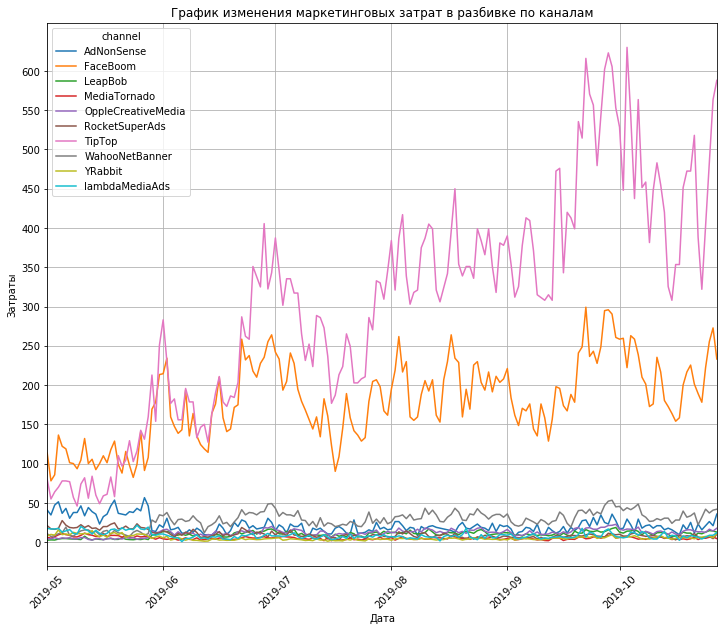

In [23]:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(12, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 

plt.yticks(np.arange(0, 650, 50)) #зададим шаг по oy
plt.title('График изменения маркетинговых затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Из графика видно, что наиболее крупные каналы (FaceBoom, TipTop) не дают возможность оценить изменения затрат на другие каналы. Два лидера не дают возможности подробнее оценить другие источники:

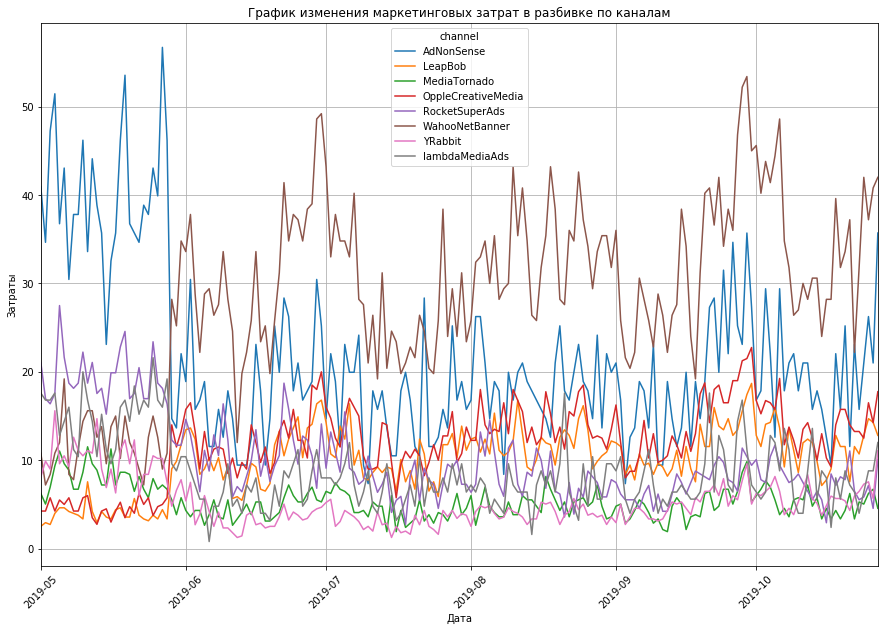

In [24]:
filtered_data2 = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )

filtered_data2.plot(                                             
           figsize=(15, 10), # размеры картинки: (x_size, y_size)
           grid=True, # отображать сетку или нет
           rot=45,        
           label='Каналы', # название линии                       
           legend=True,# выводить ли легенду к графику
           #colormap='ocean'
) 

plt.yticks(np.arange(0,  60, 10)) #зададим шаг по oy
plt.title('График изменения маркетинговых затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Видно увеличение трат на WahooNetBanner. В тоже время затраты на AdNonSense, наоборот, стали снижаться с 06.2019. 
Определим стоимость привлечения одного пользователя (информация о стоимости привлечения находится в столбце acquisition_cost:

In [25]:
profiles.describe()

# удаление органического трафика
profiles = profiles.query('channel != "organic"')

Из данных видно, что 50% выборки приходится на стоимость 0,24 ед., а вторая половина более. Таким образом, медианна стоимость привлечения составляет 0,24. Но в среднем затраты составляли 0,71 ед. Определим САС для каждого источника:

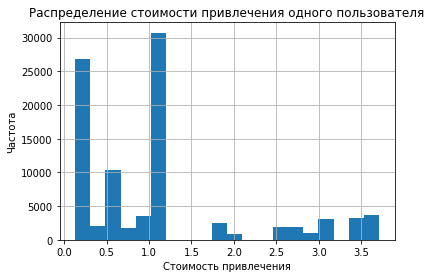

,acquisition_cost_mean
channel,
TipTop,2.8
FaceBoom,1.1
AdNonSense,1.0
lambdaMediaAds,0.7
WahooNetBanner,0.6
RocketSuperAds,0.4
OppleCreativeMedia,0.2
YRabbit,0.2
MediaTornado,0.2


In [26]:
profiles['acquisition_cost'].hist(bins = 20)
plt.title('Распределение стоимости привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()
#CAC по источникам трафика
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', ascending=False).style.format({'acquisition_cost_mean': '{:.1f}'})

Наиболее дорогим источником трафика является TipTop, средняя стоимость размещения источников составляет 2,80 ед за пользователя, цена приклечения FaceBoom и AdNonSense колеблется в границах 1,0-1,1 ед.    
В результате были сделаны следующие выводы:  
1. Общая сумма расходов на маркетинг составила 105497.3 ед. Распределение трат по источникам: большая часть TipTop (51,9% всех расходов),  на втором месте FaceBoom (30,8%), на прочие источники уходит от 0,9 до 4,9%.
2. Медианная стоимость привлечения одного покупателя составляла 0,24. При этом среднее находится на значении 0,70. Среди источников трафика самым дорогим стал TipTop, самыми дешевыми OppleCreativeMedia, YRabbit, MediaTornado, LeapBob (около 0,2 ед за привлечение пользователя).

# Шаг 5. Оцените окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

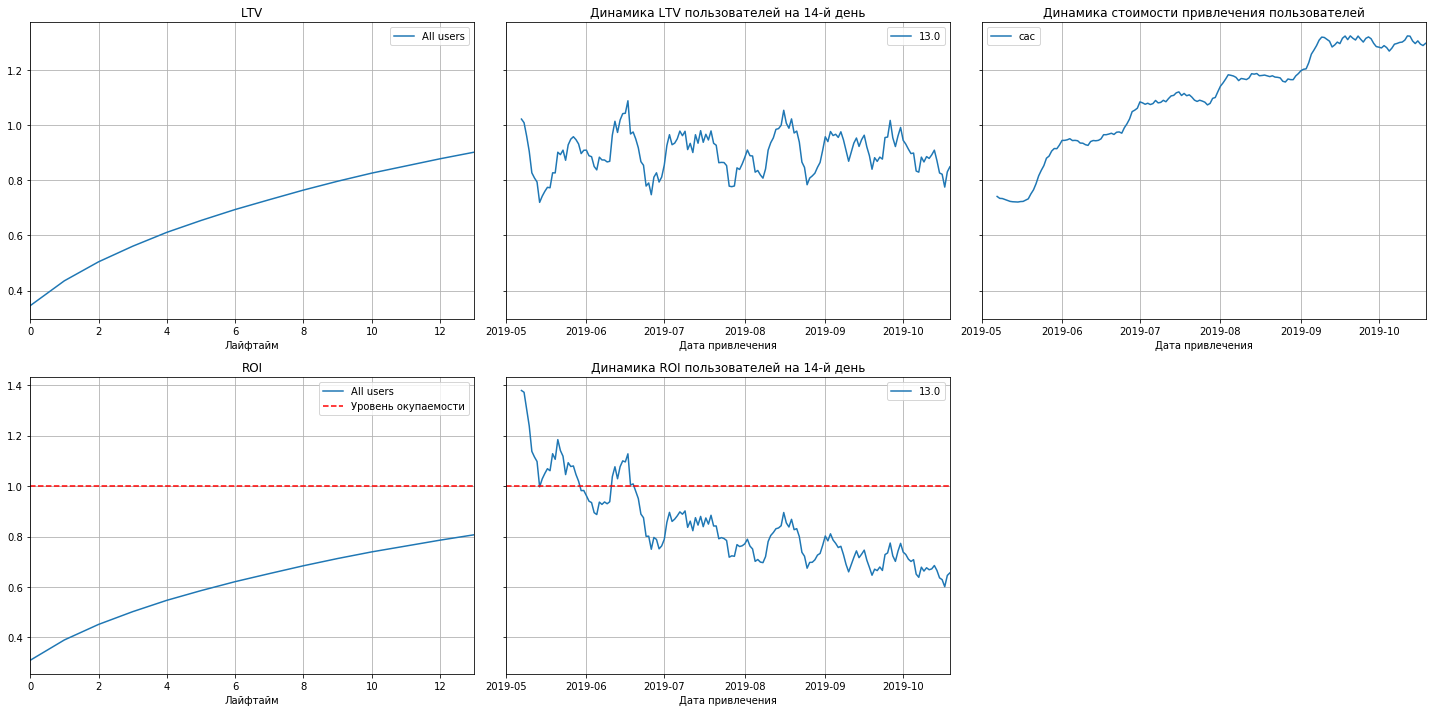

In [27]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

# LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Срок окупаемости выше 0,8 (80%), из чего следует, что реклама не окупается через рассматриваемый период 14 дней.  
Колебания динамики LTV носит сезонный характер, из чего можно сделать вывод, что дело не в пользователях. Стоимость привлечения пользователей явно растет во времени. А уровень окупаемости, наоборот, снижается.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

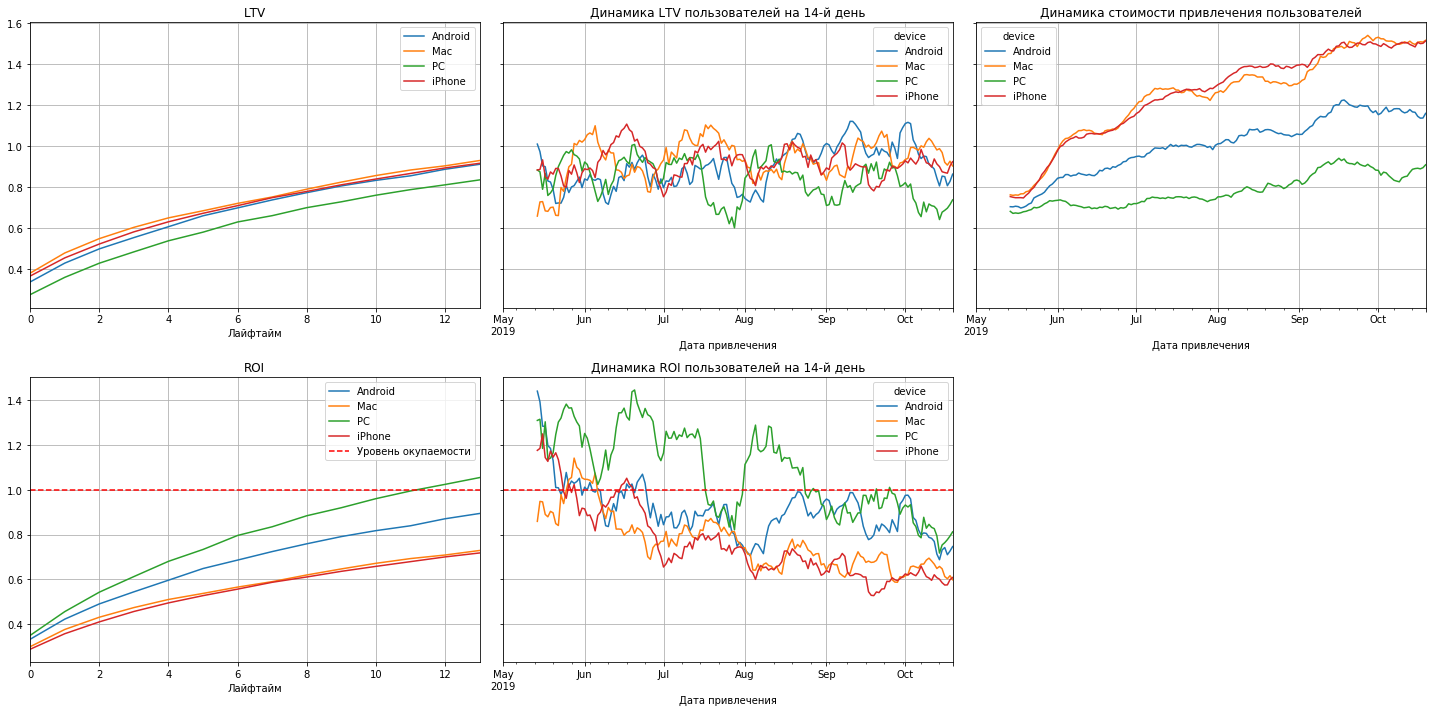

In [28]:
# окупаемость по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама не окупается везде.   
Стоимость привлечения растет на протяжении всего периода до сентября, после чего незначительно снижается для всех устройств.
LTV всё так же подвержен сезонности, но стабилен.  
Mac и iPhone стоимость привлечения высока, постоянно растет, а окупаемоcть падает.

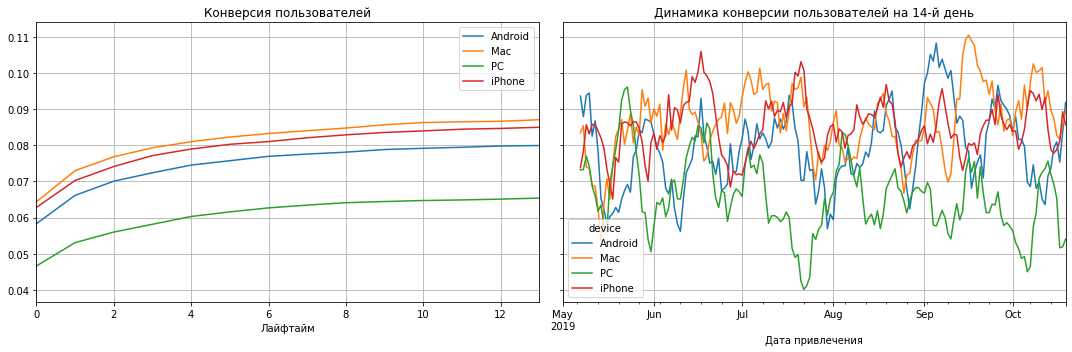

In [29]:
dimensions = ['device']
# конверсия по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Mac, Android и iPhone конвертируются хорошо, на протяжении всего периода. Раз оба канала убыточны, дело не в устройствах, а в удержании.

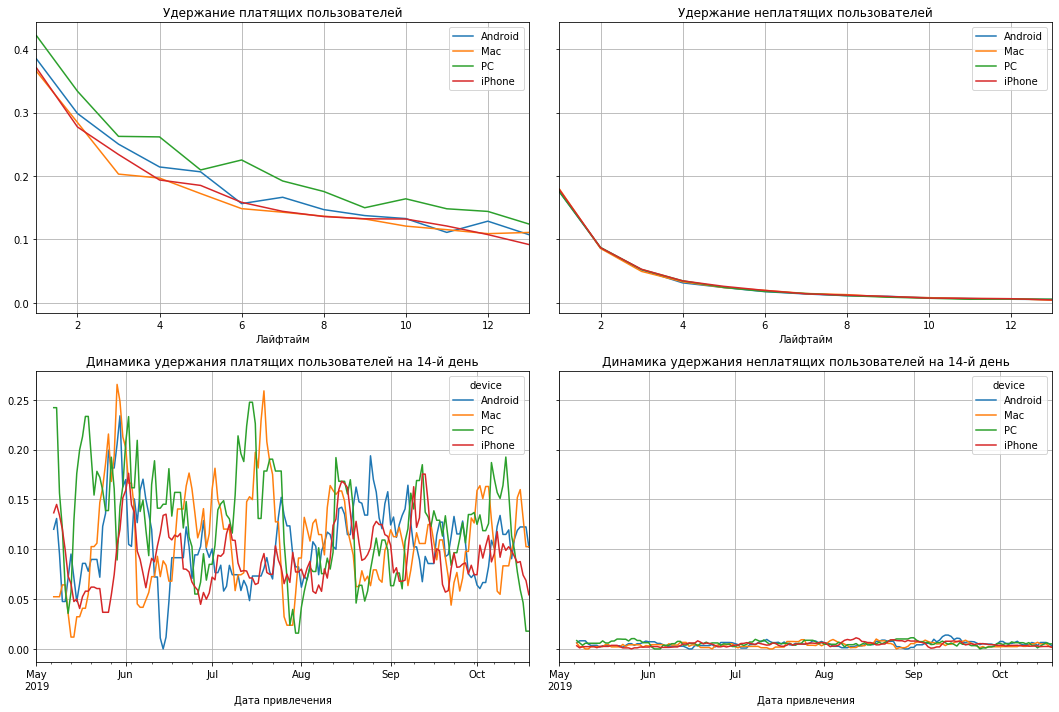

In [30]:
visits['visit_day'] = visits['session_start'].dt.date

# удержание по устройствам
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам видно, что удержание не зависит от типа устройств.

### Проанализируйте окупаемость рекламы с разбивкой по странам

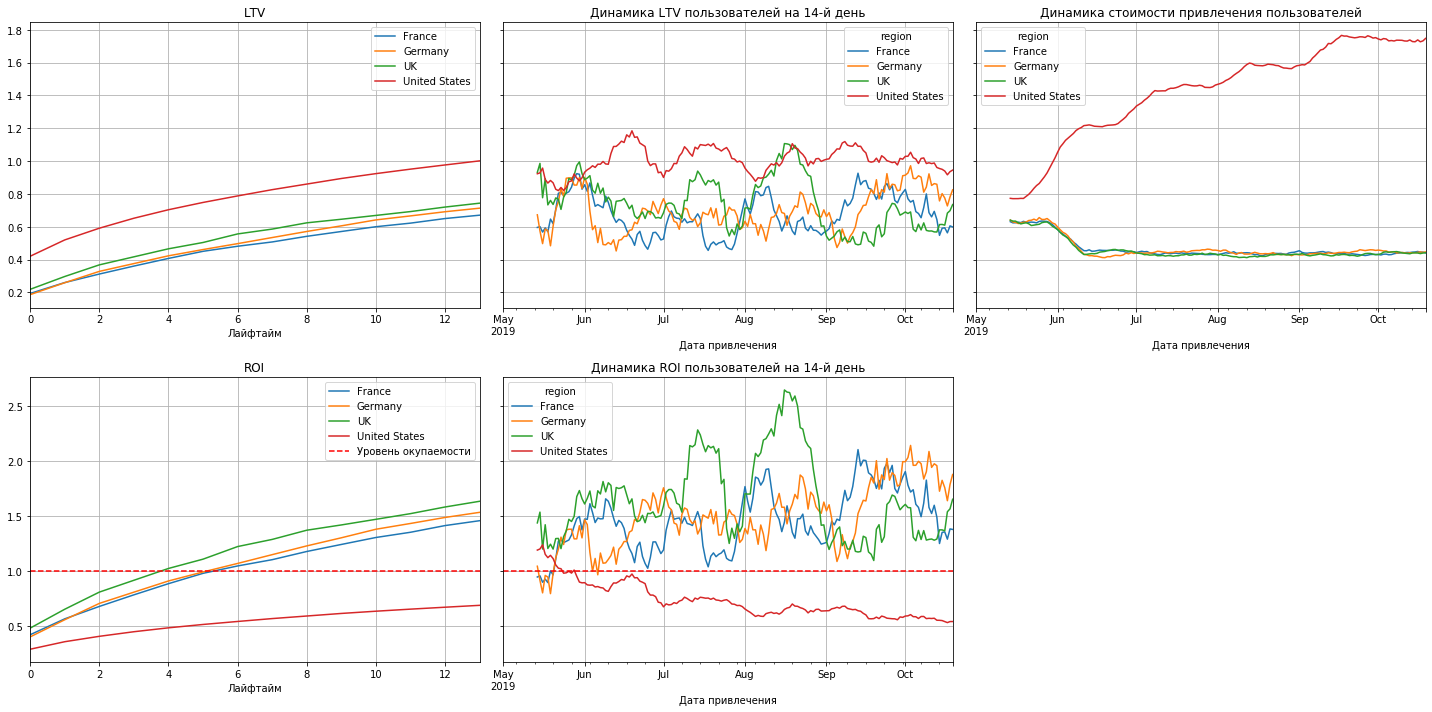

In [31]:
# окупаемость по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама окупается не во всех странах. Уровень окупаемости в США самый низкий. Ранее было выявлено, что большая часть аудитории находится в США.  
Стоимость привлечения в США на протяжении всего периода самая высокая и растет.   
Как и ранее LTV подвержен сезонности.   
Выше всего окупаемость в Великобритании и Германии. Ниже всего в США, страна явный аутсайдер. Окупаемость стала снижаться с июня 2019 г. По каким-то причинам приложение стало менее привлекательным.

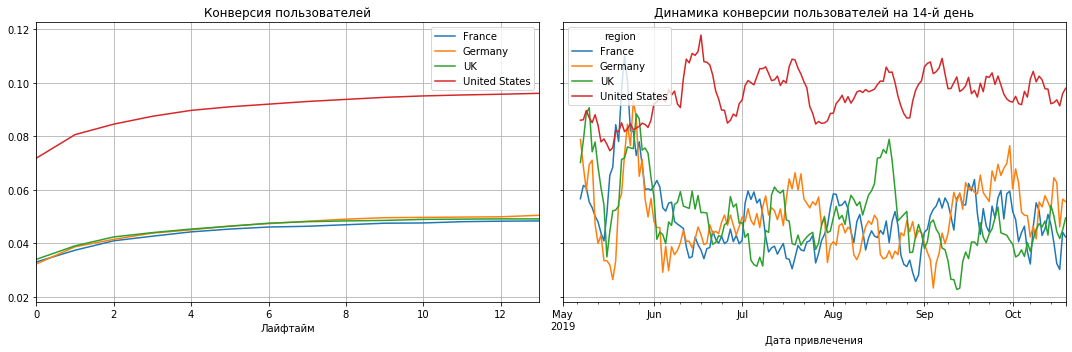

In [32]:
# конверсия по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Ниже конверсия у пользователей из Англии, Франции, Германии. Она находится примерно на одном уровне (около 0,4), в отличии от США.

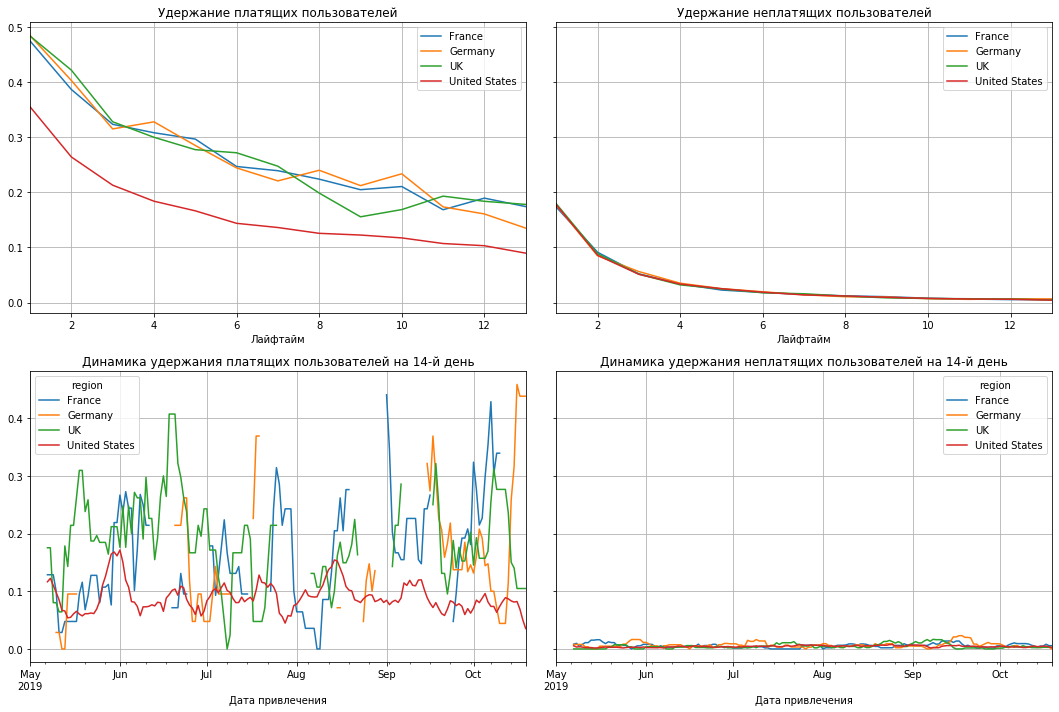

In [33]:
# удержание по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей из США очень низкое.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

Проверим, не играет ли роль реклама определенного канала.

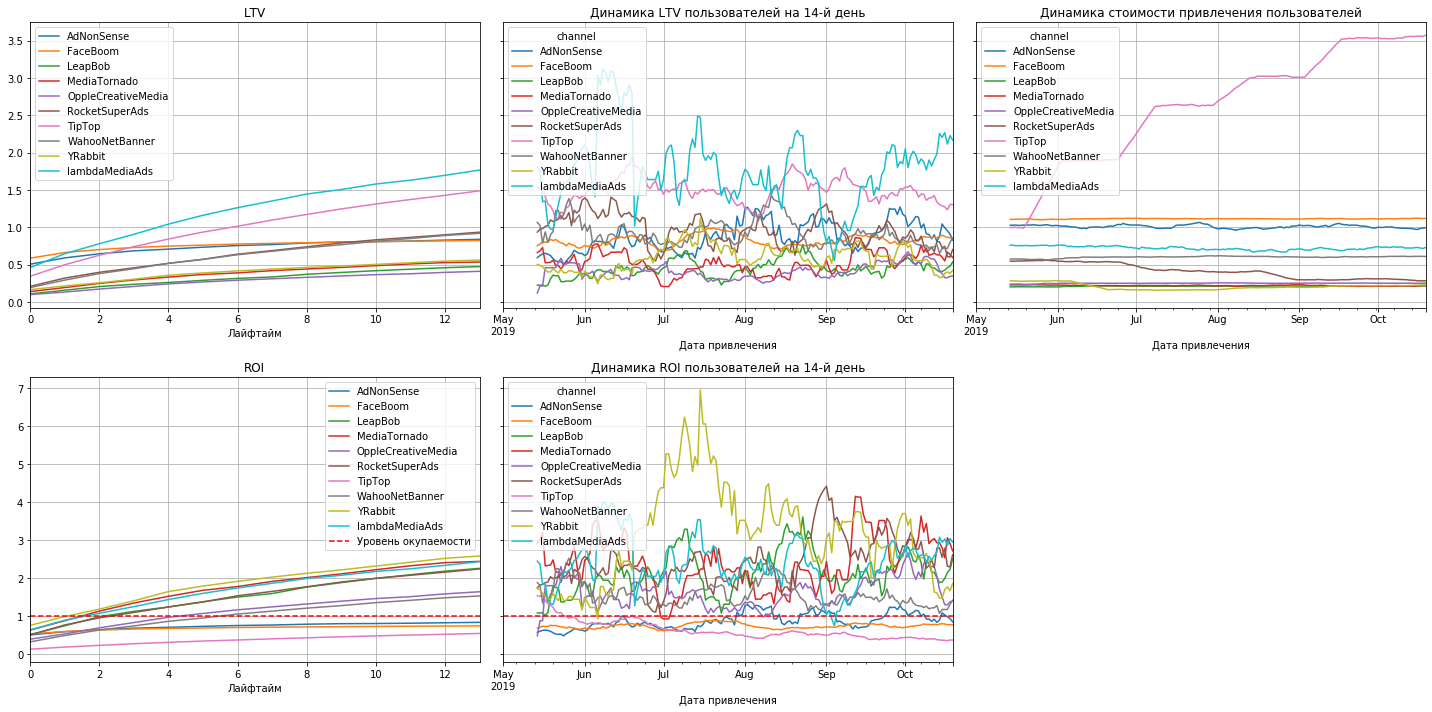

In [34]:
# окупаемость по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window = 14
) 

Наибольший рост затрат от рекламы канала TipTop. При высоких тратах аналогичного роста эффективности нет.
Не окупаются пользователи, привлеченные из каналов LeapBop, FaceBoom, TipTop.
Хорошо окупалался канал YRabbit ROI пользователей на конец второй недели в июле был высоким.

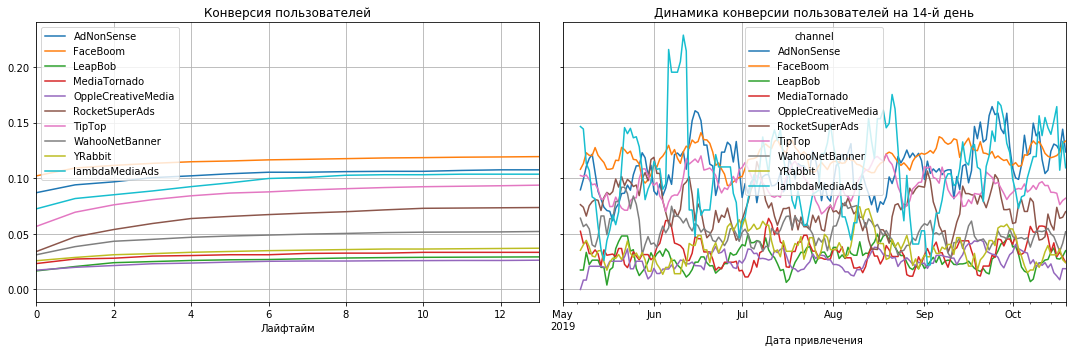

In [35]:
#конверсия по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

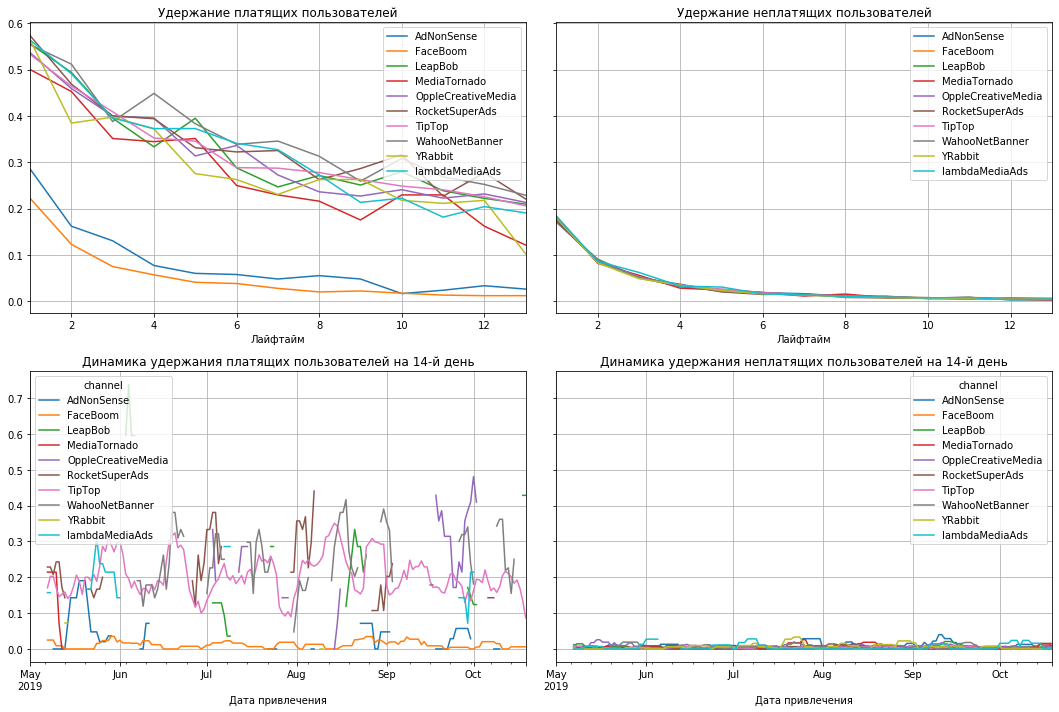

In [36]:
# удержание по каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Плохо конвертируются пользователи из каналов RocketSuperAds, MediaTornado, YRabbit. Явными аутсайдерами по удержанию являются пользователи из каналов FaceBoom, AdNonSense.

# Шаг 6. Выводы
- Причины неэффективности привлечения пользователей;
1. Выявлен рост стоимости привлечения пользователей из неэффективного рекламного канала TipTop. Следует уменьшить затраты на этот источник привлечения. 
2. Уровень окупаемости затрат на рекламу для пользователей из США в целом наиболее низкий, при этом основной аудиторией являются пользователи из США. Стоимость их привлечения самая высокая. 
3. Владельцы Mac и iPhone наиболее дорогостоящая аудитория, но окупаемость не выше остальных.
- Рекомендации для отдела маркетинга для повышения эффективности.
1. Сформировать новый маркетинговые предложения для владельцев Android, этот сегмент не самый активный, но стоимость его привлечения ниже.
2. Направить рекламный бюджет на рекламу для других стран, кроме США. Например, в Англию и Германию.
3. Следует обратить внимание на другие каналы, кроме LeapBop, FaceBoom, TipTop, которые по стоимости привлечения обходятся дешевле. Следует исключить такие удерживаются пользователи из каналов FaceBoom и AdNonSense. Можно попробовать переключить внимание на более дешевые, но прибыльные каналы.